In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 16
K = 4
NUM_SHOTS = 1024
NUM_ITERATIONS = 50

w = 0.5

approximated_energies = []

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [5]:
from scipy.optimize import minimize

### K input states (computational basis)

In [6]:
from utiles import *

In [7]:
input_states = get_first_k_eigenvectors_from_n_computational_basis(K, N)

### Ansatz State

In [8]:
from ansatz_circuit_item2 import get_full_variational_quantum_circuit

In [9]:
init_circuit_params = {
    "thetas": np.random.uniform(low=0, high=2*np.pi, size=8),
    "phis": np.random.uniform(low=0, high=2*np.pi, size=4),
    "D1": 2,
    "D2": 6
}

In [10]:
def prepare_circuit_params(thetas) -> Dict:
     return {
    "thetas": thetas[4:],
    "phis": thetas[:4],
    "D1": 2,
    "D2": 6
     }

In [11]:
def get_ansatz_state(circuit_params, input_state):
    circuit_params_with_input_state = {**circuit_params, "input_state": input_state}
    return get_full_variational_quantum_circuit(**circuit_params_with_input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [12]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [13]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [14]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [15]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [16]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [17]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [18]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [19]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [20]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian):
    circuit_params = prepare_circuit_params(thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    k_ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[K-1])
    
    approximated_energey = get_expectation_value(k_ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(approximated_energey)
    
    L_w = w*approximated_energey
    for j in range(K-1):
        ansatz_state = get_ansatz_state(circuit_params, computational_eigenvectors[j])
        L_w += get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        
    return L_w

## Optimization

In [21]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=12)
    optimizer_result = minimize(cost_function,x0=initial_thetas,args=(hamiltonian),method="BFGS",options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = prepare_circuit_params(optimizer_result.x)
    
    return optimal_thetas

In [22]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian)
    print(optimal_thetas)
    computational_eigenvectors = get_first_k_eigenvectors_from_n_computational_basis(K, N)
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, computational_eigenvectors[K-1])
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [23]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [24]:
def get_k_exact_eigenvalue_of_hamiltonian(hamiltonian, k):
    eigen_values = LA.eig(hamiltonian.to_matrix())[0]
    print(sorted(eigen_values, reverse=True))
    
    return sorted(eigen_values,reverse=True)[k-1]

In [25]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_k_exact_eigenvalue_of_hamiltonian(hamiltonian, K)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("Approximated K Eigenvalues:")
    print(approximated_eigenvalue)

    print("Approximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))

## Visualization

In [26]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [27]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [28]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits)

{'thetas': array([1.9538282 , 2.00282206, 4.18749215, 0.23821936, 4.16489294,
       6.26764867, 1.63147381, 4.8886056 ]), 'phis': array([5.93702955, 2.47213602, 0.95418515, 5.28590286]), 'D1': 2, 'D2': 6}
CPU times: total: 2h 11min 42s
Wall time: 2h 49min 53s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

[(-6.769813218087976+0j), (-7.130406955301308+0j), (-7.130406955301309+0j), (-7.151525481896562+0j), (-7.364817440287081+0j), (-7.511999706834451+0j), (-7.511999706834453+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.700475837803976+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.7140566916607005+0j), (-7.783396208286518+0j), (-7.7833962082865185+0j), (-7.862773163027979+0j)]
Exact Eigenvalue:
(-7.151525481896562+0j)
Approximated K Eigenvalues:
-7.599391135645403
Approximation Error
0.062625191629754


In [31]:
print(approximated_energies)
approximated_energies = []

[-7.5811722185398285, -7.59159646344728, -7.591712498431583, -7.5823144711155255, -7.601228227804495, -7.5736138923664065, -7.599055184917277, -7.595389384370309, -7.586873555877376, -7.586779572764962, -7.587446891289177, -7.58816416037616, -7.606319025241597, -7.5468150612323015, -7.54795274923913, -7.561365217492775, -7.560844694104422, -7.548328551094029, -7.556729381819861, -7.5501822152874825, -7.552787397268313, -7.567509848511693, -7.573107964123815, -7.541648049799553, -7.546799664950377, -7.53654352129788, -7.589160003564084, -7.578598759247515, -7.590933004721402, -7.588143540217285, -7.594244897237276, -7.587510169441045, -7.5868306475144776, -7.587602605379268, -7.59225930178968, -7.5988486139694436, -7.573672664147123, -7.587077981079782, -7.589894569667096, -7.593989957965422, -7.5934638061012665, -7.586978945437706, -7.576471075379983, -7.586002143566326, -7.593009863418946, -7.594930172385808, -7.588512242648442, -7.60293471934649, -7.591877985644651, -7.58096938015012

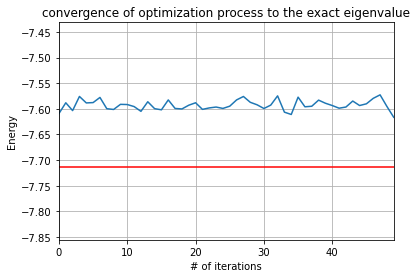

In [29]:
LiH_approximated_energies = [-7.5811722185398285, -7.59159646344728, -7.591712498431583, -7.5823144711155255, -7.601228227804495, -7.5736138923664065, -7.599055184917277, -7.595389384370309, -7.586873555877376, -7.586779572764962, -7.587446891289177, -7.58816416037616, -7.606319025241597, -7.5468150612323015, -7.54795274923913, -7.561365217492775, -7.560844694104422, -7.548328551094029, -7.556729381819861, -7.5501822152874825, -7.552787397268313, -7.567509848511693, -7.573107964123815, -7.541648049799553, -7.546799664950377, -7.53654352129788, -7.589160003564084, -7.578598759247515, -7.590933004721402, -7.588143540217285, -7.594244897237276, -7.587510169441045, -7.5868306475144776, -7.587602605379268, -7.59225930178968, -7.5988486139694436, -7.573672664147123, -7.587077981079782, -7.589894569667096, -7.593989957965422, -7.5934638061012665, -7.586978945437706, -7.576471075379983, -7.586002143566326, -7.593009863418946, -7.594930172385808, -7.588512242648442, -7.60293471934649, -7.591877985644651, -7.580969380150128, -7.596119932713606, -7.615516216961582, -7.596055304700592, -7.5996270334260725, -7.586983361838935, -7.596246225349671, -7.590777615173849, -7.5935751302098256, -7.592837174684869, -7.603790076682524, -7.6093363504202145, -7.60522230882189, -7.577824083506902, -7.583940898791256, -7.585838556976443, -7.591352114525316, -7.586985421943245, -7.590516288197774, -7.592645661018166, -7.6022590957403695, -7.591330646171517, -7.594369777609106, -7.588063188591844, -7.590887567834473, -7.58529252287314, -7.590260727471608, -7.592442375670534, -7.588704468391091, -7.589907345471134, -7.594705545462669, -7.6098627506974665, -7.595941589491842, -7.594781927195355, -7.583709436067628, -7.601491453462858, -7.597492855351171, -7.596534669869249, -7.588718115470418, -7.580497184080997, -7.583102004301224, -7.591826652364619, -7.5996868685846355, -7.588597363608952, -7.5813554074546055, -7.583835495117783, -7.59064434908851, -7.58437365137141, -7.590315760666925, -7.597855922766573, -7.590740727486217, -7.596056737044825, -7.5902279046692325, -7.609184282492802, -7.591748265755058, -7.602981872142157, -7.59998915723516, -7.588200490143084, -7.591025078502806, -7.588051902013782, -7.611052590540253, -7.587486622263765, -7.591803731736747, -7.589835728854846, -7.593340824035681, -7.581866774777097, -7.58836662913097, -7.6053870554693805, -7.590489094786991, -7.580771153453858, -7.5905219906055565, -7.602079027418958, -7.59869534734383, -7.592327067764258, -7.586492679563721, -7.5900307096383495, -7.605871180701457, -7.583686251845164, -7.59084383030994, -7.591011259270283, -7.609378670021997, -7.602092819996155, -7.5890139534539784, -7.586869308169689, -7.585646372448603, -7.58076297152655, -7.609251035755286, -7.591515311689081, -7.59257083904225, -7.584083715434293, -7.586450125487619, -7.593598728550749, -7.580488061773295, -7.605496242684976, -7.593414651298946, -7.60217927693839, -7.576912879829302, -7.604154147713128, -7.6084567317964975, -7.578611304029224, -7.591686370715707, -7.596609189738003, -7.5779236456467185, -7.600899390110624, -7.589656688978693, -7.591824476469537, -7.588295121277478, -7.604646934476692, -7.599305159948481, -7.601823274459693, -7.599153286574935, -7.59398640868234, -7.594623264414274, -7.563535780759224, -7.5907374418716795, -7.584497327439853, -7.598880523136912, -7.589930732585632, -7.596773581756135, -7.5820404386071925, -7.591745408563035, -7.595021082718484, -7.591871643380514, -7.5923783623174295, -7.588662444757317, -7.601348684176666, -7.604692130795216, -7.581271720491602, -7.592316763268401, -7.599557460899818, -7.590233868866651, -7.60106633139657, -7.591029502106871, -7.590946526294125, -7.578047392804944, -7.584371216579831, -7.58297181596419, -7.593260068364673, -7.588794164898488, -7.595498777698822, -7.57844959725151, -7.601455854688926, -7.591515635688625, -7.5844746837553405, -7.590480735122996, -7.59115080196329, -7.583228595085926, -7.591838539639781, -7.5880938775924935, -7.591635548561748, -7.591955549690062, -7.598088450438071, -7.582096714835912, -7.588480649207663, -7.575017322673416, -7.591209269166958, -7.582617613707098, -7.596106095701603, -7.562895071846649, -7.581176362485807, -7.578569198893786, -7.591395966192013, -7.589017847713364, -7.576334250015566, -7.587794803768129, -7.616990543910279, -7.5906539038020435, -7.586853063919036, -7.585559440057858, -7.584803368513558, -7.597555640231412, -7.595228097920501, -7.595190095630545, -7.590903350802588, -7.591718676589801, -7.586795506030791, -7.580612481966594, -7.593603416733997, -7.598238714945253, -7.605972868167942, -7.584061079920518, -7.587272086190425, -7.60479190195469, -7.6013951681300655, -7.593690915438579, -7.599320500571691, -7.58002377916205, -7.597620308675762, -7.595205045762717, -7.601282182510587, -7.5764528159136475, -7.58003542137329, -7.577500526862233, -7.585601464645433, -7.594348998755124, -7.594659687853514, -7.584691274533544, -7.579260346160663, -7.589381346695482, -7.581942488616398, -7.585761838931412, -7.5888806656223, -7.5906512594778786, -7.59460061471894, -7.598291131300036, -7.566077017354454, -7.598568920462468, -7.588458586865334, -7.580516851783573, -7.581120795801359, -7.573401531185061, -7.587906649375854, -7.577894400309903, -7.588650004367097, -7.601671473700583, -7.6045987582499, -7.587960747276149, -7.586668925102221, -7.598896396820583, -7.584992838351697, -7.588738488491178, -7.592081956817983, -7.594450290229943, -7.577207933669749, -7.592589318566335, -7.591631016036065, -7.586822528718511, -7.5865236423006515, -7.575498534956321, -7.574278911271381, -7.584707709876169, -7.590472728393561, -7.599499257712318, -7.589231395611416, -7.597168903183947, -7.590381517053034, -7.603836632255566, -7.593864793429861, -7.600191191390682, -7.586817716211005, -7.587970682164855, -7.588438308757338, -7.586491923661776, -7.5849299950060445, -7.5726557026548, -7.605430277807631, -7.583551608530619, -7.590313233780737, -7.582464090187332, -7.587898000394051, -7.57869966024508, -7.59814204971804, -7.58368253706408, -7.583281132917466, -7.596340009605541, -7.580639556870499, -7.594986105182591, -7.597986634078884, -7.605014774124471, -7.595227520703942, -7.6126847535198445, -7.599313575341617, -7.569816760702087, -7.594416054247172, -7.605083757930927, -7.582868819170454, -7.586396258585806, -7.604414920719065, -7.599387572834845, -7.594782011899959, -7.606698086162534, -7.599912812617114, -7.609221282226267, -7.588232008218757, -7.60346462535037, -7.57588689646886, -7.588493577576002, -7.587845316302236, -7.577824438147921, -7.59972110610129, -7.601255963829907, -7.591292742933581, -7.591643875142415, -7.595608436976339, -7.604907684584499, -7.586236901477843, -7.599687143227731, -7.6019079185697205, -7.582693582623832, -7.599300342093287, -7.600243633211197, -7.592954405838291, -7.58819349398165, -7.601064555573852, -7.598241391296196, -7.596549098561609, -7.599227365949463, -7.594832883549281, -7.582626984810636, -7.5759575479403365, -7.587274253615891, -7.592166994254732, -7.599369142236348, -7.592745920229135, -7.574743004640935, -7.6065301484133485, -7.6110277743814025, -7.577220966905672, -7.596052441127596, -7.594975868864067, -7.583058349968933, -7.58912555988364, -7.593591137603428, -7.598784448149547, -7.596526026783077, -7.584847627840902, -7.593575746597375, -7.590229568191782, -7.579561798198312, -7.57274335076671, -7.595408728174156, -7.616555806795029]
plot_convergence_of_optimization_process(LiH_approximated_energies, exact_eigenvalue=-7.7140566916607005,margin=1)

## H2 Molecule 4 qubits

In [33]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits)

{'thetas': array([5.65863505, 6.23071243, 1.49937188, 1.81287997, 1.18032958,
       0.50814838, 1.00856067, 0.71227251]), 'phis': array([2.04303338, 1.56290588, 1.50985954, 2.55935251]), 'D1': 2, 'D2': 6}
CPU times: total: 51min 14s
Wall time: 54min 47s


In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

[(0.2142782384194731+0j), (-1.942890293094024e-16+0j), (-0.2249112528308709+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.47189600728114245+0j), (-0.47189600728114256+0j), (-0.8827221502448648+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-1.244584549813327+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.2563390730032498+0j), (-1.25633907300325+0j), (-1.8572750302023793+0j)]
Exact Eigenvalue:
(-0.353325104107155+0j)
Approximated K Eigenvalues:
-0.6474050763310082
Approximation Error
0.8323211931600133


In [36]:
print(approximated_energies)
approximated_energies = []

[-0.6197535280860968, -0.63113013317311, -0.641885414639814, -0.6482547418356555, -0.65455000829844, -0.6441486895522341, -0.6186687021257633, -0.6337374526097435, -0.63137130321273, -0.6515250743774067, -0.6579678475184173, -0.6398929213318618, -0.6555847628548984, -0.40354990528583756, -0.42633959272606203, -0.39180257499975996, -0.419385140488104, -0.4052452163765543, -0.3968392598264421, -0.41327196278701983, -0.3897682032307278, -0.41190320628798593, -0.4155349659846535, -0.38689315655724943, -0.39488576584884966, -0.4101577563997251, -0.646246089992425, -0.64640556215564, -0.6408025316083132, -0.6481729361748543, -0.6321210801588072, -0.6169734445936428, -0.6531880101925263, -0.6516595101969759, -0.6370106901252102, -0.6410493390206395, -0.6549643568126738, -0.6434282271634354, -0.6374465180654254, -0.6998006222609853, -0.6989411616133739, -0.7113515779782615, -0.6845563444533804, -0.6912851288084605, -0.6823206756219158, -0.6715092561687758, -0.6950950360064898, -0.7048125041323

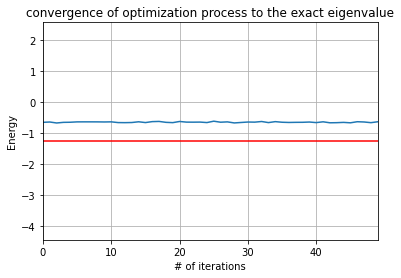

In [30]:
H2_approximated_energies = [-0.6197535280860968, -0.63113013317311, -0.641885414639814, -0.6482547418356555, -0.65455000829844, -0.6441486895522341, -0.6186687021257633, -0.6337374526097435, -0.63137130321273, -0.6515250743774067, -0.6579678475184173, -0.6398929213318618, -0.6555847628548984, -0.40354990528583756, -0.42633959272606203, -0.39180257499975996, -0.419385140488104, -0.4052452163765543, -0.3968392598264421, -0.41327196278701983, -0.3897682032307278, -0.41190320628798593, -0.4155349659846535, -0.38689315655724943, -0.39488576584884966, -0.4101577563997251, -0.646246089992425, -0.64640556215564, -0.6408025316083132, -0.6481729361748543, -0.6321210801588072, -0.6169734445936428, -0.6531880101925263, -0.6516595101969759, -0.6370106901252102, -0.6410493390206395, -0.6549643568126738, -0.6434282271634354, -0.6374465180654254, -0.6998006222609853, -0.6989411616133739, -0.7113515779782615, -0.6845563444533804, -0.6912851288084605, -0.6823206756219158, -0.6715092561687758, -0.6950950360064898, -0.7048125041323035, -0.6949055673239051, -0.6876195557523046, -0.6871916327390696, -0.6920620441807598, -0.6754031102431696, -0.6405037528920269, -0.6479106194443648, -0.6571243727534537, -0.6585210677012743, -0.6619852684486195, -0.6306692686820092, -0.6426806791628032, -0.6605101341410042, -0.6581734283582826, -0.6602845191858175, -0.6403463546120416, -0.6838573980740288, -0.6367601998705805, -0.6389697979320161, -0.6342448131512901, -0.6275459264150375, -0.6397639594996816, -0.6516652787828084, -0.6568333186072677, -0.6337354077401545, -0.6534843394293214, -0.6561183148929468, -0.6394550125097977, -0.6282040909709646, -0.6566726955439391, -0.6480962237754406, -0.6391249852824691, -0.6302805184048759, -0.6134825837204779, -0.6324807924099654, -0.648200184148801, -0.6411199725353807, -0.6368985204497558, -0.6299450915767432, -0.6077929487594798, -0.650795244723779, -0.6364396855992979, -0.6561074752564185, -0.6411855472811453, -0.6636963692795997, -0.644828181245867, -0.6426381659395819, -0.6395444214753829, -0.6428019435419277, -0.6477507227847618, -0.6245247077953339, -0.6524683695964778, -0.657026854334116, -0.6358256453202371, -0.6549216159614076, -0.6414823984346717, -0.6559324505625062, -0.6184921814281965, -0.6243527663890307, -0.6347039342445667, -0.6423667818441274, -0.6416632437237163, -0.6355679476249553, -0.6101453551739199, -0.6428657380183808, -0.6371993803542474, -0.6190951873626491, -0.6300491872725141, -0.6443076254087124, -0.6346503527906344, -0.6374022072525142, -0.6365415695138426, -0.6215329044766564, -0.6025672090796137, -0.6262126292580317, -0.6121655900183715, -0.6372581587495586, -0.6532601474080465, -0.6502386208320281, -0.6374473928211839, -0.649108661977176, -0.6428978019524852, -0.6377680232901412, -0.62148731332837, -0.6295014947278836, -0.6303577746392046, -0.6311824700622705, -0.6485908334116913, -0.6555308247607579, -0.6387533756242247, -0.6387831688041341, -0.6362224138123854, -0.6321326357150927, -0.622886094438443, -0.6381661184242305, -0.6207598749285432, -0.633337235851305, -0.6433014163336428, -0.6216780295166963, -0.640547648407052, -0.6504721343163778, -0.6289231121104825, -0.6420313548519503, -0.6491871272384829, -0.6303753733515429, -0.6422070448022406, -0.6283882694196357, -0.6379372975401341, -0.6298035124355486, -0.6376118905742243, -0.6112071558166968, -0.6243668348101994, -0.601586210931813, -0.6246804576520302, -0.6225112843707201, -0.6385828114683393, -0.6308445065147489, -0.6459667238092578, -0.6420608286322824, -0.6284852174798609, -0.619517446532688, -0.6502311414153916, -0.6209974249236357, -0.6500441487817326, -0.6270160102758754, -0.6321138163295283, -0.6318213468032534, -0.6308663247351938, -0.6351155382454959, -0.6206589579897115, -0.6230425476232493, -0.6457261606370266, -0.638217697666363, -0.5967596291858532, -0.6308080357393553, -0.645343139596654, -0.6361652737273936, -0.6216439843718955, -0.6381345598638063, -0.6436054044017382, -0.6402634016890136, -0.6286637688911421, -0.6176910501936059, -0.6426835317643965, -0.6392144191408344, -0.6379698862857323, -0.6294007310483538, -0.6536384710745602, -0.6358065891830973, -0.6281936714944539, -0.6198882142883465, -0.6667152509756108, -0.6478727132696764, -0.639743219643381, -0.6594605134740277, -0.6208263182667817, -0.6484844194562659, -0.6560350644220397, -0.6400305393668726, -0.6082390327656634, -0.6177097860668552, -0.6444776983490096, -0.6405638061358565, -0.6531983360761086, -0.6384666560316292, -0.6026381248979216, -0.6205265201994276, -0.6580811400893553, -0.6242879958522837, -0.6256237085721144, -0.6370627576610521, -0.6193780381228698, -0.6110480817069229, -0.6348741804124418, -0.6469297212858536, -0.6284047197112129, -0.6425857646008404, -0.6227145680975487, -0.6543951355139729, -0.6135377860147931, -0.6151008019528299, -0.6332371262963544, -0.6213803615123089, -0.6197342220002152, -0.6553553047211762, -0.6542865700842904, -0.6447201703460987, -0.607866355025946, -0.6300084394962439, -0.6411144050158086, -0.6178965245521646, -0.616191998658104, -0.6348708952923955, -0.623907264080751, -0.641086457337346, -0.6444154604034792, -0.621800174387, -0.6244882763185394, -0.6376556734303133, -0.6375013731590747, -0.6275068048204745, -0.6623644844595649, -0.630649046531283, -0.6548727406536676, -0.6362997093395338, -0.6061815282744116, -0.6546951895602897, -0.6309023807683508, -0.6508388161226021, -0.6385027712100855, -0.6190137561886869, -0.6696046214509908, -0.6562145856438492, -0.6186112558608597, -0.6473301190677272, -0.6462712478136641, -0.673403768067784, -0.6530082059325099, -0.6543125213926978, -0.6378511211667697, -0.6345475633154861, -0.6368035646034413, -0.6420046649037825, -0.6415451595381126, -0.6447601324975634, -0.6308090659348322, -0.6442243984560325, -0.6337552468237352, -0.6652098463681152, -0.6450651275200792, -0.6415608484514996, -0.6297426007842335, -0.628971981721844, -0.6290368436378584, -0.6296828008139378, -0.6326057245473052, -0.6287268748618635, -0.6523495046628819, -0.654514736278266, -0.6503390006896462, -0.6267667849085593, -0.6518861485724909, -0.6213049629142335, -0.6152511068093129, -0.6444920885486036, -0.6538763157213386, -0.6169162063050543, -0.6374557936296323, -0.639117369570508, -0.636462951162852, -0.6517593736006154, -0.6076877031233741, -0.6403602223149248, -0.6298396251235469, -0.6637221198146037, -0.64886754893841, -0.6345453470146507, -0.6382894853660541, -0.6177025318805094, -0.652638852060324, -0.622038295932382, -0.6415029691455418, -0.6482039684567894, -0.6444058652688481, -0.6431931740464266, -0.6348402433271942, -0.6526661449410499, -0.6274506541843567, -0.6588510196703152, -0.6552920830042773, -0.6460730559750325, -0.6595908999970469, -0.6246926245873604, -0.6332020529350273, -0.6548958894755552, -0.6261489147202579]
plot_convergence_of_optimization_process(H2_approximated_energies, exact_eigenvalue=-1.2445845498133272, margin=5)

##  Transverse Ising Model 4 qubits

In [31]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

In [32]:
%%time
TI_approximated_eigen_value = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits)

{'thetas': array([2.63159468, 1.42161475, 5.29596792, 3.09754364, 5.48273075,
       5.20058532, 4.15002043, 1.11781189]), 'phis': array([1.75248019, 3.62609827, 4.9005435 , 2.78011246]), 'D1': 2, 'D2': 6}
CPU times: total: 22min 5s
Wall time: 23min 1s


In [33]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

NameError: name 'TI_approximated_eigenvalue' is not defined

In [ ]:
print(approximated_energies)
approximated_energies = []

In [ ]:
TI_approximated_energies = [1.8984375, 1.943359375, 1.9619140625, 1.978515625, 1.984375, 1.9873046875, 1.9931640625, 1.9248046875, 1.962890625, 1.9248046875, 1.9150390625, 1.9052734375, 1.9267578125, 1.802734375, 1.81640625, 1.86328125, 1.8623046875, 1.7939453125, 1.8623046875, 1.89453125, 1.880859375, 1.8388671875, 1.8720703125, 1.83984375, 1.8837890625, 1.8359375, 1.701171875, 1.7470703125, 1.69140625, 1.73828125, 1.833984375, 1.69921875, 1.7744140625, 1.7529296875, 1.7353515625, 1.7265625, 1.7666015625, 1.708984375, 1.7421875, 1.79296875, 1.8671875, 1.91015625, 1.8828125, 1.884765625, 1.875, 1.86328125, 1.85546875, 1.8134765625, 1.84375, 1.79296875, 1.865234375, 1.8916015625, 1.908203125, 1.900390625, 1.8837890625, 1.876953125, 1.896484375, 1.9921875, 1.9208984375, 1.94921875, 1.96875, 1.8466796875, 1.92578125, 1.8740234375, 1.9716796875, 1.9130859375, 1.939453125, 1.9599609375, 1.9716796875, 1.9150390625, 1.98828125, 1.865234375, 1.9248046875, 1.890625, 2.0146484375, 1.9560546875, 1.947265625, 1.9619140625, 1.955078125, 1.9208984375, 1.955078125, 1.9384765625, 1.96484375, 1.9150390625, 1.923828125, 1.9580078125, 1.958984375, 2.013671875, 1.935546875, 1.9443359375, 2.0546875, 2.001953125, 1.958984375, 1.98828125, 1.962890625, 2.0205078125, 2.0029296875, 1.93359375, 1.91015625, 1.9765625, 1.9365234375, 1.8984375, 1.9072265625, 1.939453125, 1.9033203125, 2.0556640625, 1.947265625, 1.9267578125, 1.9541015625, 1.962890625, 1.9287109375, 1.9072265625, 1.962890625, 1.966796875, 1.9560546875, 1.970703125, 1.9580078125, 1.9833984375, 2.013671875, 1.966796875, 1.9599609375, 1.943359375, 1.974609375, 1.9619140625, 1.9462890625, 1.974609375, 1.9482421875, 1.943359375, 1.9697265625, 1.9033203125, 1.9794921875, 1.98828125, 1.94140625, 1.9658203125, 2.0078125, 1.9912109375, 1.916015625, 1.916015625, 2.0068359375, 1.9130859375, 1.9267578125, 1.90234375, 1.921875, 1.943359375, 1.9755859375, 1.90234375, 1.95703125, 1.9482421875, 1.97265625, 1.9658203125, 1.990234375, 1.9384765625, 1.935546875, 1.916015625, 1.91796875, 1.99609375, 1.87109375, 1.9599609375, 1.919921875, 1.951171875, 1.9521484375, 1.9716796875, 1.9736328125, 1.9794921875, 1.99609375, 1.9765625, 1.9228515625, 1.9482421875, 1.9462890625, 1.986328125, 1.927734375, 1.9482421875, 2.0771484375, 2.0009765625, 1.9267578125, 1.9638671875, 1.904296875, 1.9365234375, 1.962890625, 1.958984375, 1.96875, 1.9521484375, 1.8935546875, 1.916015625, 1.939453125, 1.98046875, 1.9560546875, 1.9541015625, 1.955078125, 1.9228515625, 1.9951171875, 1.93359375, 1.9736328125, 1.9443359375, 1.96484375, 1.984375, 1.8681640625, 1.923828125, 1.947265625, 1.96484375, 1.94140625, 1.9375, 1.96875, 1.94921875, 1.943359375, 1.8935546875, 1.9638671875, 1.912109375, 2.0, 1.921875, 2.064453125, 1.95703125, 1.9287109375, 1.951171875, 1.982421875, 1.8955078125, 1.9482421875, 1.9970703125, 1.9423828125, 1.9697265625, 1.90625, 1.9306640625, 1.9716796875, 1.92578125, 1.98046875, 1.9521484375, 1.9072265625, 1.962890625, 1.9365234375, 1.9609375, 1.9560546875, 1.9462890625, 2.0166015625, 1.9609375, 1.9287109375, 1.962890625, 1.9677734375, 1.9169921875, 1.876953125, 1.9443359375, 1.984375, 1.9697265625, 1.978515625, 1.958984375, 1.9677734375, 2.0341796875, 1.9697265625, 1.93359375, 1.966796875, 1.9482421875, 1.9345703125, 1.9453125, 1.9912109375, 1.986328125, 1.955078125, 1.927734375, 2.03125, 1.921875, 1.951171875, 1.9990234375, 1.8955078125, 1.9794921875, 2.0078125, 1.9580078125, 1.986328125, 1.9287109375, 1.9853515625, 1.9990234375, 1.9365234375, 2.0048828125, 1.9462890625, 1.9580078125, 1.970703125, 1.951171875, 1.91015625, 1.8662109375, 1.9013671875, 1.9267578125, 1.943359375, 1.9814453125, 1.927734375, 1.99609375, 1.9580078125, 1.904296875, 1.912109375, 1.978515625, 1.9453125, 1.990234375, 1.97265625, 1.9580078125, 1.93359375, 1.9599609375, 1.986328125, 1.970703125, 1.966796875, 1.947265625, 1.875, 1.953125, 1.966796875, 1.931640625, 1.9140625, 1.98828125, 1.919921875, 1.970703125, 1.8916015625, 2.0615234375, 2.015625, 1.8466796875, 1.916015625, 1.96875, 1.9697265625, 2.0029296875, 1.9326171875, 1.939453125, 1.873046875, 1.9345703125, 1.9501953125, 1.927734375, 1.9453125, 2.005859375, 1.96484375, 1.9384765625, 1.9609375, 1.990234375, 1.951171875, 1.951171875, 1.994140625, 2.015625, 1.9462890625, 1.94140625, 2.0439453125, 1.9755859375, 1.9326171875, 2.0224609375, 1.9248046875, 1.990234375, 2.0, 1.9091796875, 1.9267578125, 1.951171875, 1.95703125, 1.9521484375]
plot_convergence_of_optimization_process(TI_approximated_energies, exact_eigenvalue=-1.7583827504312988, margin=3)